<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-2/blob/main/P1_Aug11_1_AIML425_Assn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()  # To make sure the output is in [0,1] range for a 2D uniform box
        )

    def forward(self, x):
        return self.fc(x)


In [3]:
num_samples = 1000

# Generate Z
Z = torch.randn(num_samples, 2)

# Y will be uniform so you can use the uniform function from torch
Y = torch.rand(num_samples, 2)


In [4]:
batch_sizes = [32, 64, 128]  # example batch sizes, you can choose your own
dataset = TensorDataset(Z, Y)


In [5]:
def compute_mmd(x, y, kernel):
    xx = kernel(x, x)
    yy = kernel(y, y)
    xy = kernel(x, y)
    return xx.mean() + yy.mean() - 2*xy.mean()

def rbf_kernel(x, y, sigma=1.0):
    d = x.unsqueeze(1) - y.unsqueeze(0)
    s = -torch.sum(d**2, dim=2) / (2*sigma**2)
    return torch.exp(s)


In [7]:
def train_model(batch_size, max_epochs, dataset, device):
    model = FullyConnected().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    loss_history = []

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(max_epochs):
        for batch_Z, batch_Y in loader:
            batch_Z, batch_Y = batch_Z.to(device), batch_Y.to(device)

            optimizer.zero_grad()

            outputs = model(batch_Z)
            loss = compute_mmd(outputs, batch_Y, rbf_kernel)
            loss.backward()
            optimizer.step()

        loss_history.append(loss.item())
    return model, loss.item(), loss_history

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_loss = float('inf')
best_epoch = -1
best_batch_size = -1
best_loss_history = []

for index, batch_size in enumerate(batch_sizes):
    model, loss, loss_history = train_model(batch_size, 500, dataset, device)

    if loss < best_loss:
        best_loss = loss
        best_epoch = index  # Adjust this if you need exact epoch number
        best_batch_size = batch_size
        best_model = model.state_dict()
        best_loss_history = loss_history

print(f"Best Model at Epoch: {best_epoch} with Batch Size: {best_batch_size}")
torch.save(best_model, 'best_model.pth')

Best Model at Epoch: 2 with Batch Size: 128


In [8]:
best_model = FullyConnected().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

with torch.no_grad():
    y_pred = best_model(Z.to(device)).cpu()


# Plot

In [9]:
def plot_loss(losses, ax):
    ax.set_title("Training and Validation Loss of Model")
    ax.plot(losses,label="Training")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

def plot_y(y, ax):
    y_np = y.cpu().detach().numpy()

    # Extract x and y coordinates for plotting
    x_coords, y_coords = y_np[:, 0], y_np[:, 1]

    # Plot on the provided axes
    ax.scatter(x_coords, y_coords, s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

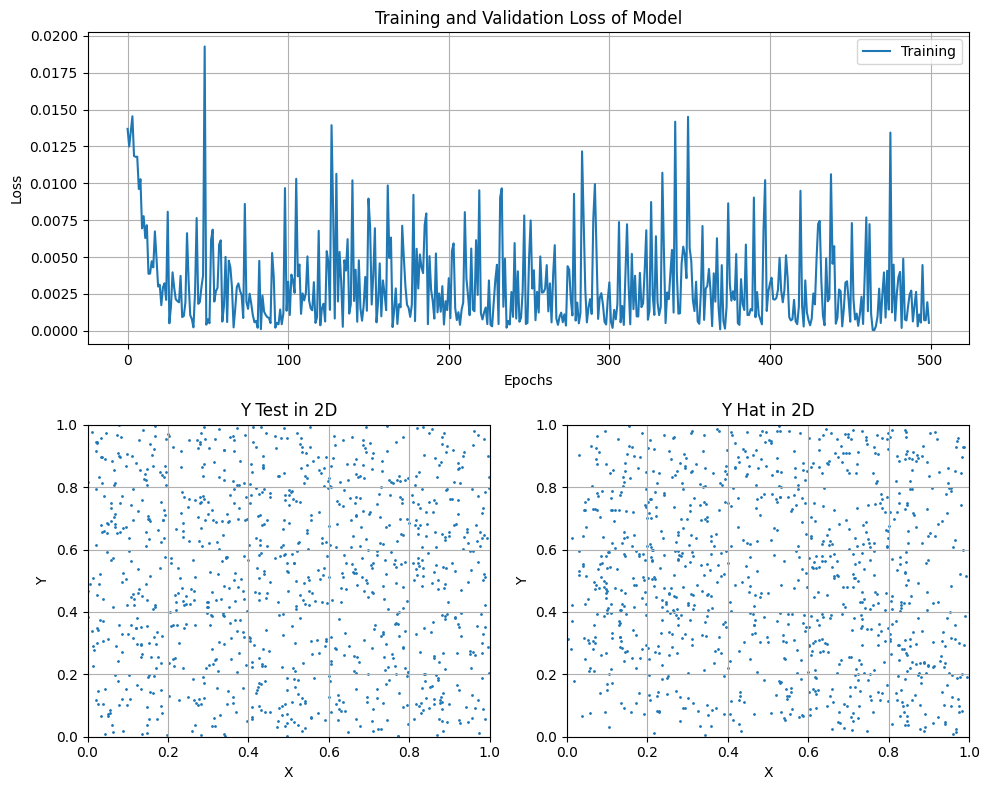

In [10]:
# Create figure
fig = plt.figure(figsize=(10, 8))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

# Define the axes using the grid layout
ax1 = plt.subplot(gs[0, :])  # This axis spans both columns of the first row
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

# Plot on the defined axes
plot_loss(loss_history, ax1)
plot_y(Y, ax2)
ax2.set_title("Y Test in 2D")
plot_y(y_pred, ax3)
ax3.set_title("Y Hat in 2D")

plt.tight_layout()
plt.show()